# Prepare data with (48, 16, 16) (train, val, test) split for each catetory

In [ ]:
#load dataset zip from url to memory and unzip the file
!wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
!unzip -qq sketches_png.zip

--2020-06-17 14:23:25--  http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
Resolving cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)... 130.149.80.52
Connecting to cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)|130.149.80.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550098987 (525M) [application/zip]
Saving to: ‘sketches_png.zip’

sketches_png.zip    100%[===================>] 524.62M  24.7MB/s    in 34s     

2020-06-17 14:23:59 (15.5 MB/s) - ‘sketches_png.zip’ saved [550098987/550098987]



In [ ]:
#making required imports
import os 
import cv2
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

In [ ]:
# making fastai imports
import fastai
from fastai.vision import *

In [ ]:
#et src_dir location
src_dir = 'png'

In [ ]:
#read all labels into csv to get image path and class labels for each image
df = pd.read_csv('png/filelist.txt', names=['img_path'])
df['class'] = df['img_path'].apply(lambda x: x.split('/')[0])
df.head()

,img_path,class
0,airplane/1.png,airplane
1,airplane/10.png,airplane
2,airplane/11.png,airplane
3,airplane/12.png,airplane
4,airplane/13.png,airplane


In [ ]:
#define function to split data into (train, val, test) in ratio (0.6, 0.2, 0.2)
def split_dataframe(df):
    x, x_test = train_test_split(df, stratify=df['class'], test_size=0.2, random_state=0)
    x_train, x_val = train_test_split(x, stratify=x['class'], test_size=0.25, random_state=0)

    return x_train.index, x_val.index, x_test.index

In [ ]:
#split dataframe into 12000 train images and 4000 each for validation and test with (48, 16, 16) (train, val, test) images for each class
train_df, val_df, test_df = split_dataframe(df)

In [ ]:
#set image size and batch size
img_size=256
batch_size = 128

In [ ]:
#define data object which resizes each image to defined image size and loads them into batches of batch size
data = (ImageList.from_df(df, path='png')
        .split_by_idxs(train_df, val_df)
        .label_from_df(cols=['class']) 
        .transform(get_transforms(), size=img_size, resize_method=ResizeMethod.SQUISH)
        .add_test(ImageList.from_df(df.iloc[test_df], path='png'))
        .databunch(bs=batch_size).normalize(imagenet_stats)    
       )

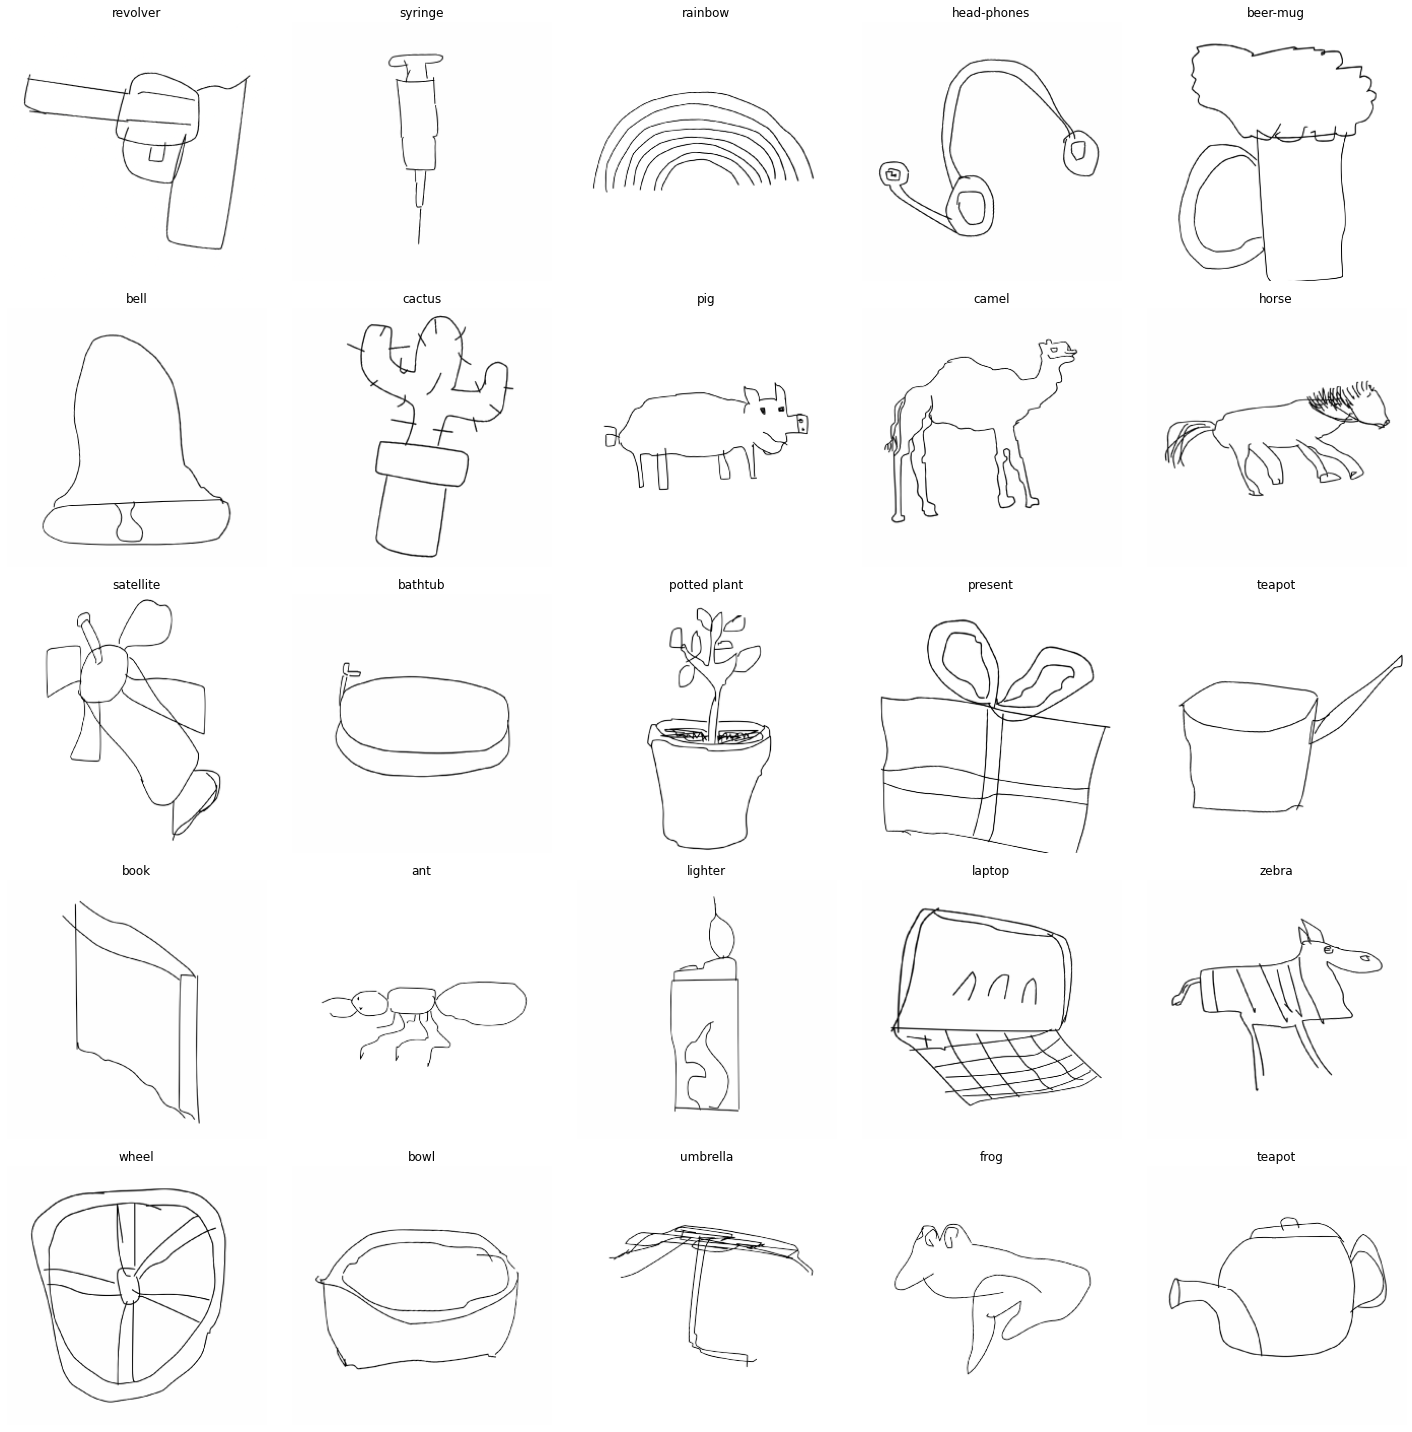

In [ ]:
# show images in a batch
data.show_batch()

# Image Classification model

In [ ]:
# define model with pretrained weights of ResNet34 and download the weights

learn = cnn_learner(data, models.resnet34, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.20E-02


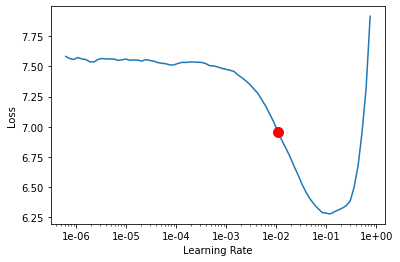

In [ ]:
#plot learning rate vs. loss for one epoch to find the range of best learning rates for training
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# fit model for 5 epochs with learning rate slice(2e-2)
learn.fit_one_cycle(7, slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.712621,2.037625,0.513750,09:05
1,2.632138,1.680703,0.573500,09:03
2,1.890021,1.314750,0.650500,09:02
3,1.454324,1.150280,0.684250,09:10
4,1.155760,1.052891,0.716250,09:10
5,0.880949,0.954215,0.744750,09:08
6,0.704615,0.926649,0.748500,09:09


In [ ]:
#save the weights for the model till now
learn.save('stage1')
print("weights saved at 'png/models'")

weights saved at 'png/models'


In [ ]:
#unfreeze the layers of the pre-trained model to have a better fit 
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.63E-06


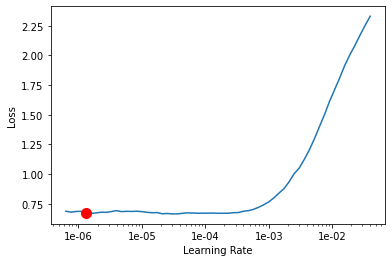

In [ ]:
#again find the best range of learning rate to provide to retrain the model
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#fit the model for 7 epochs with the lr range(1e-6, 2e-4)
learn.fit_one_cycle(7, slice(1e-6, 2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.634085,0.922828,0.750750,09:19
1,0.637541,0.895434,0.760000,09:23
2,0.614433,0.876577,0.765750,09:19
3,0.570886,0.870477,0.769000,09:20
4,0.522848,0.864609,0.770000,09:17
5,0.501152,0.858994,0.769500,09:18
6,0.490697,0.858750,0.768750,09:16


In [ ]:
#save the model weights
learn.save('stage2')

In [ ]:
#define data object which resizes each image to defined image size and loads them into batches of batch size
data = (ImageList.from_df(df, path='png')
        .split_by_idxs(train_df, val_df)
        .label_from_df(cols=['class']) 
        .transform(get_transforms(), size=512, resize_method=ResizeMethod.SQUISH)
        .add_test(ImageList.from_df(df.iloc[test_df], path='png'))
        .databunch(bs=24).normalize(imagenet_stats)    
       )

In [ ]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


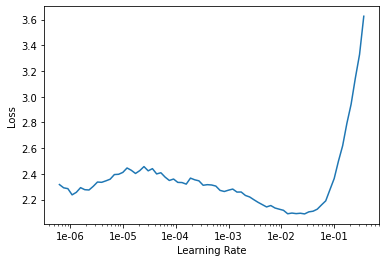

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#fit the model for 5 epochs
learn.fit_one_cycle(5, slice(1e-2/2))

epoch,train_loss,valid_loss,accuracy,time
0,1.439113,1.144292,0.690500,23:35
1,1.482394,1.115302,0.697250,23:07
2,1.212312,0.976151,0.735500,22:53
3,0.930218,0.909445,0.751750,21:52
4,0.761231,0.883995,0.761250,21:15


In [ ]:
learn.save('stage1-res34-512')

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


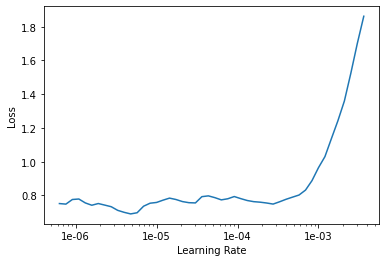

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#fit the model for 5 epochs
learn.fit_one_cycle(5, slice(3e-6, 2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.726126,0.900793,0.759500,22:29
1,0.780079,0.872508,0.765250,21:23
2,0.665708,0.842423,0.772750,22:23
3,0.550714,0.811068,0.777250,21:18
4,0.456777,0.803357,0.780250,23:06


In [ ]:
learn.save('stage2-res34-512')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


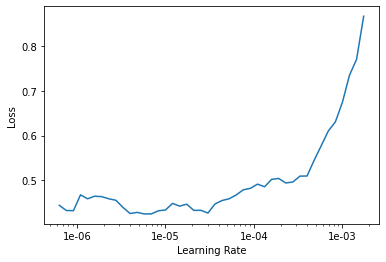

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#fit the model for 3 epochs
learn.fit_one_cycle(3, slice(2e-6, 2e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.469086,0.797969,0.781000,23:17
1,0.492747,0.803589,0.777250,24:03
2,0.409284,0.802095,0.780750,23:54


In [ ]:
learn.save('stage3-res34-512')

## get test accuracy

In [ ]:
probabilities, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
preds = torch.argmax(probabilities, dim=1)

In [ ]:
predictions = [data.classes[pred] for pred in preds]

In [ ]:
predictions

['pretzel',
 'envelope',
 'power outlet',
 'church',
 'bear (animal)',
 'blimp',
 'speed-boat',
 'chair',
 'dolphin',
 'speed-boat',
 'mushroom',
 'tooth',
 'microscope',
 'brain',
 'blimp',
 'traffic light',
 'radio',
 'hammer',
 'trousers',
 'nose',
 'keyboard',
 'ashtray',
 'monkey',
 'pigeon',
 'dolphin',
 'sun',
 'parking meter',
 'paper clip',
 'beer-mug',
 'blimp',
 'snail',
 'standing bird',
 'crab',
 'parachute',
 'submarine',
 'human-skeleton',
 'camera',
 'walkie talkie',
 'umbrella',
 'sea turtle',
 'motorbike',
 'revolver',
 'crown',
 'submarine',
 'owl',
 'crocodile',
 'barn',
 'rabbit',
 'keyboard',
 'octopus',
 'crane (machine)',
 'person walking',
 'chandelier',
 'cabinet',
 'door',
 'horse',
 'pear',
 'mermaid',
 'ship',
 'present',
 'bush',
 'mushroom',
 'door handle',
 'eye',
 'present',
 'pig',
 'couch',
 'cigarette',
 'satellite dish',
 'tire',
 'binoculars',
 'ant',
 'kangaroo',
 'snail',
 'race car',
 'pig',
 'cup',
 'guitar',
 'castle',
 'space shuttle',
 'pige

In [ ]:
df.iloc[test_df]

,img_path,class
13056,pretzel/13057.png,pretzel
6015,envelope/6016.png,envelope
12958,power outlet/12959.png,power outlet
4213,church/4214.png,church
14831,sheep/14832.png,sheep
...,...,...
7594,grenade/7595.png,grenade
8125,head/8126.png,head
11899,pear/11900.png,pear
6931,flying bird/6932.png,flying bird


In [ ]:
preds_df = df.iloc[test_df]

In [ ]:
preds_df['preds'] = predictions

In [ ]:
preds_df

,img_path,class,preds
13056,pretzel/13057.png,pretzel,pretzel
6015,envelope/6016.png,envelope,envelope
12958,power outlet/12959.png,power outlet,power outlet
4213,church/4214.png,church,church
14831,sheep/14832.png,sheep,bear (animal)
...,...,...,...
7594,grenade/7595.png,grenade,grenade
8125,head/8126.png,head,face
11899,pear/11900.png,pear,pear
6931,flying bird/6932.png,flying bird,angel


In [ ]:
def accuracy(preds_df):
  c = 0
  for idx, row in preds_df.iterrows():
    if(row['class']==row['preds']):
      c+=1
  return c/4000

In [ ]:
print(accuracy(preds_df))

0.789


# Make Predictions

In [ ]:
#function to get predictions into a dataframe
def get_predictions(model, df, img_idx_list, src_dir):
  #make lists of image paths and predictions
  img_paths, preds = [], []
  for path in list(df.iloc[img_idx_list]['img_path']):
    #load image
    img = open_image(os.path.join(src_dir, path))
    #get predictions
    pred_class,_,_ = model.predict(img)
    #append img_path and pred to lists
    img_paths.append(path)
    preds.append(str(pred_class))
  
  #save predictions to a dataframe of img_path, preds
  pred_df = pd.DataFrame({'img_path': img_paths, 'preds': preds})

  #return dataframe
  return pred_df

In [ ]:
#store predictions for 50 test images preds_df dataframe
preds_df = get_predictions(model=learn, df=df, img_idx_list=test_df[:50], src_dir='png')

In [ ]:
preds_df

,img_path,preds
0,pretzel/13057.png,pretzel
1,envelope/6016.png,envelope
2,power outlet/12959.png,power outlet
3,church/4214.png,church
4,sheep/14832.png,bear (animal)
5,blimp/1847.png,blimp
6,speed-boat/15866.png,speed-boat
7,chair/4073.png,chair
8,dolphin/5361.png,dolphin
9,speed-boat/15863.png,speed-boat


# Cluster Images based on semantic similarity

In [ ]:
#import spacy library to get pretrained language corpus
import spacy
#import Agglomerative Clustering from sklearn
from sklearn.cluster import AgglomerativeClustering

In [ ]:
#import spacy's english corpus
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# define word2vec model(spacy's pretrained english corpus)
nlp = spacy.load('en_core_web_lg')

In [ ]:
nlp('pigeon').vector.shape

(300,)

In [ ]:
#function to form clusters based on semantic similarity
def form_clusters(sim_thresh, preds_df,  word2vec):
    #Calculating number of categories found
    n_uni_cat = preds_df['preds'].nunique()
    print("{} unique categories found".format(n_uni_cat))
    
    print("Please wait...clustering may take some time...")
    #Saving all categories as list
    cat_lst = list(preds_df['preds'].unique())
    #Initialising cosine distance matrix of shape (n_uni_cls, n_cls)
    X = np.zeros(shape=(n_uni_cat, n_uni_cat))
    
    # Filling pairwise cosine distance for all unique categories in matrix
    for i in range(n_uni_cat):
        for j in range(n_uni_cat):
          #cosine distance = 1 - cosine similarity
          X[i][j] = 1 - word2vec(cat_lst[i]).similarity(word2vec(cat_lst[j]))
    
    #Define Cluster object with threshold value
    cluster = AgglomerativeClustering(affinity='precomputed', linkage='average',
                                      distance_threshold=1-sim_thresh, n_clusters=None)
    #fit data to cluster
    cluster.fit(X)      
    #Print number of clusters
    print("{} clusters formed based on similarity threshold {}".format(max(cluster.labels_)+1, sim_thresh))
    
    #save cluster no. for each category into cluster dictionary
    clust_dict = {cat: cluster.labels_[idx]  for idx, cat in enumerate(cat_lst)}
        
    preds_df['clust no.'] = preds_df['preds'].map(clust_dict)
    #return the the changed dataframe
    return preds_df

In [ ]:
# get cluster number for each image with similarity threshold=0.43
updated_df = form_clusters(sim_thresh=0.43, preds_df=preds_df, word2vec=nlp)

44 unique categories found
Please wait...clustering may take some time...
28 clusters formed based on similarity threshold 0.43


# Display Clusters

In [ ]:
%matplotlib inline

In [ ]:
# function to display images in grid format
def grid_display(cluster_no, list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):
    
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [ ]:
#function to display images in a specific cluster number
def display_cluster(df, cluster_no, src_dir, no_of_imgs_in_row=2):
    #form empty lists for paths of images and preds
    img_list, preds_list = [], []
    
    #make list of images
    for path in list(df[df['clust no.']==cluster_no]['img_path']):
        #read each image using path
        img = cv2.imread(os.path.join(src_dir,path))
        #append image to list
        img_list.append(img)
    
    #make list of predictions
    for pred in list(df[df['clust no.']==cluster_no]['preds']):
        #append prediction to list
        preds_list.append(pred)
    
    #grid display
    grid_display(cluster_no, img_list, preds_list, no_of_imgs_in_row)

In [ ]:
updated_df.groupby('clust no.')['clust no.'].value_counts()

clust no.  clust no.
0          0            2
1          1            7
2          2            2
3          3            2
4          4            2
5          5            4
6          6            4
7          7            1
8          8            1
9          9            1
10         10           1
11         11           1
12         12           5
13         13           1
14         14           1
15         15           2
16         16           1
17         17           1
18         18           1
19         19           1
20         20           1
21         21           2
22         22           1
23         23           1
24         24           1
25         25           1
26         26           1
27         27           1
Name: clust no., dtype: int64

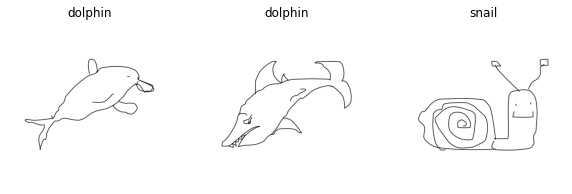

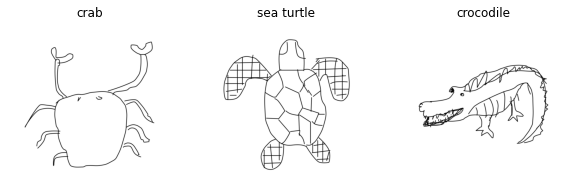

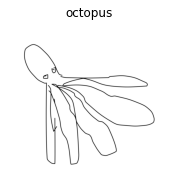

In [ ]:
display_cluster(df=updated_df, cluster_no=1, src_dir=src_dir, no_of_imgs_in_row=3)

# Get predictions on the whole dataset and then form clusters



In [ ]:
#store predictions for all test images preds_df dataframe
probabilities, _ = learn.get_preds(ds_type=DatasetType.Test)
preds = torch.argmax(probabilities, dim=1)
predictions = [data.classes[pred] for pred in preds]
preds_df = df.iloc[test_df]
preds_df['preds'] = predictions

In [ ]:
preds_df.to_csv('test_preds-res34-789.csv')

In [ ]:
# get cluster number for each image with similarity threshold=0.43
updated_df = form_clusters(sim_thresh=0.43, preds_df=preds_df, word2vec=nlp)

250 unique categories found
Please wait...clustering may take some time...
85 clusters formed based on similarity threshold 0.43


In [ ]:
updated_df['clust no.'].value_counts()

18    262
4     252
24    140
6     139
17    136
     ... 
64     15
42     14
48     14
43     14
78      9
Name: clust no., Length: 85, dtype: int64

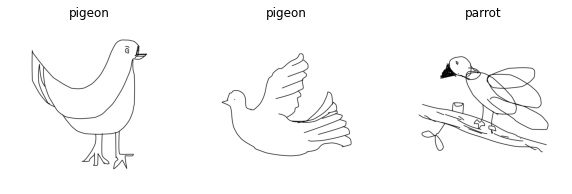

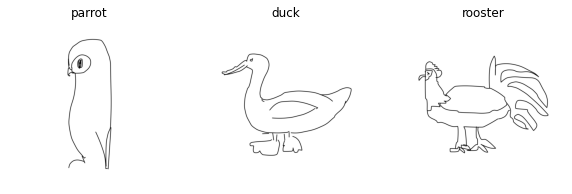

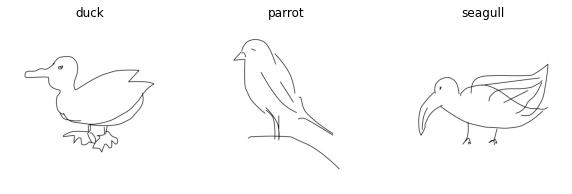

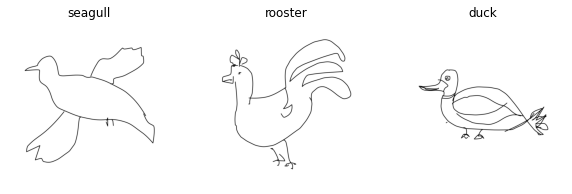

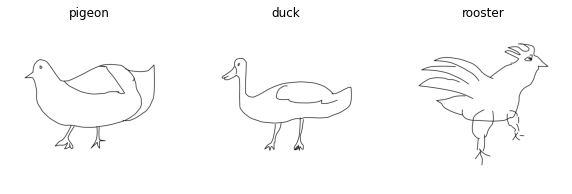

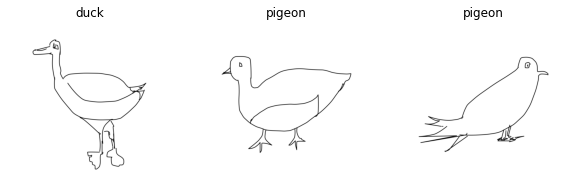

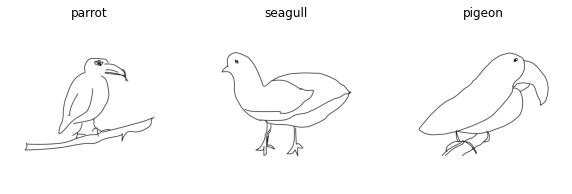

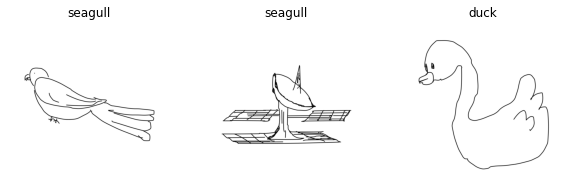

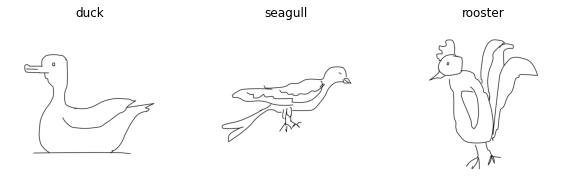

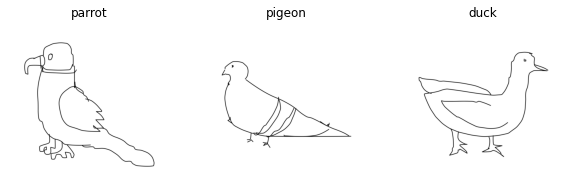

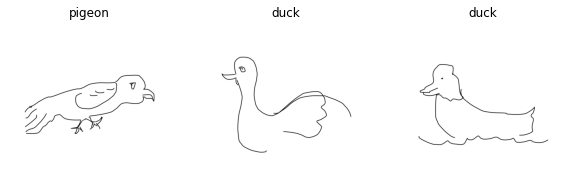

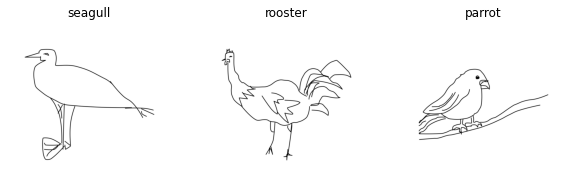

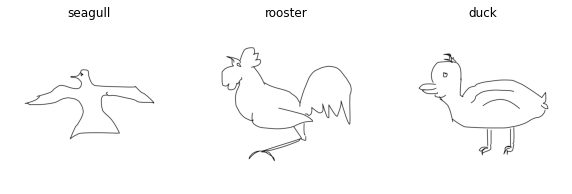

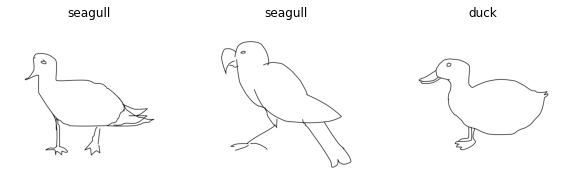

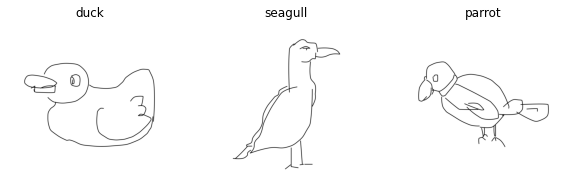

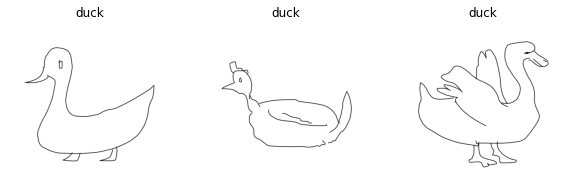

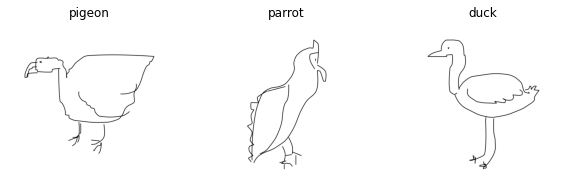

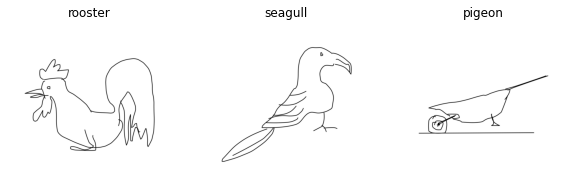

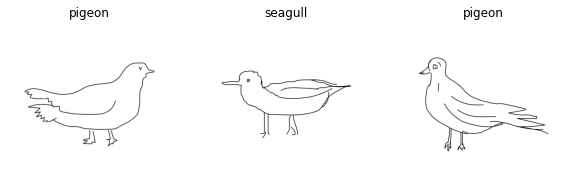

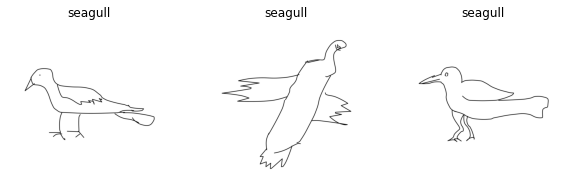

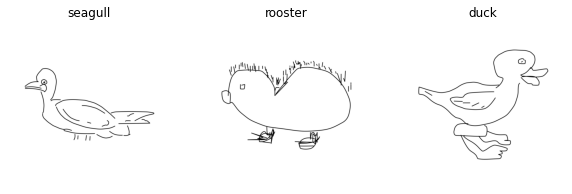

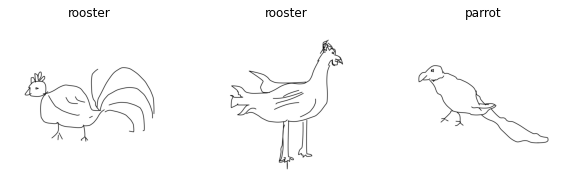

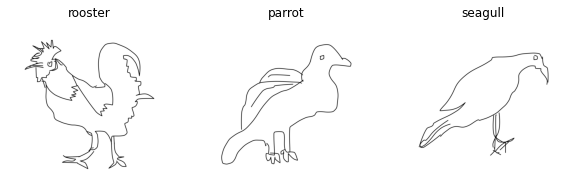

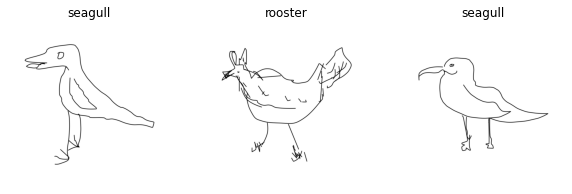

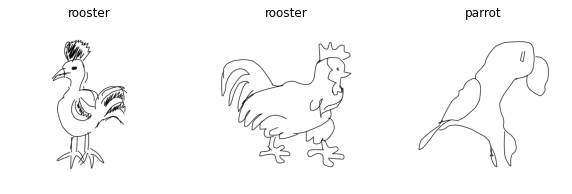

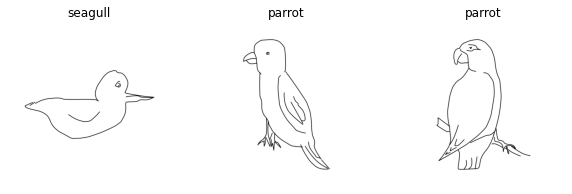

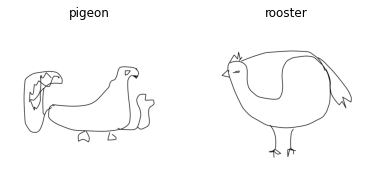

In [ ]:
display_cluster(df=updated_df, cluster_no=1, src_dir=src_dir, no_of_imgs_in_row=3)

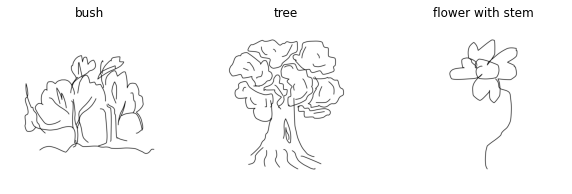

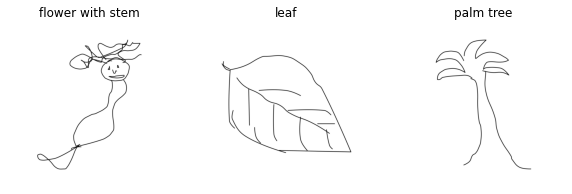

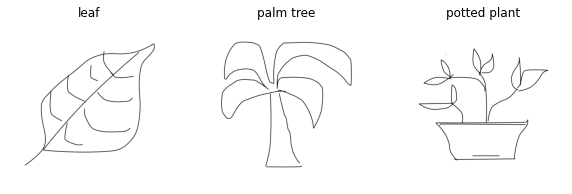

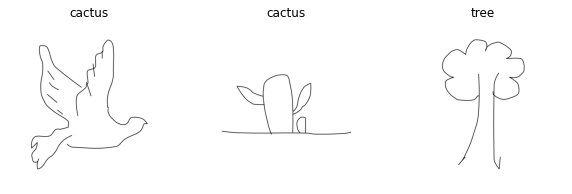

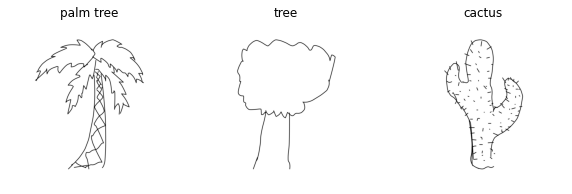

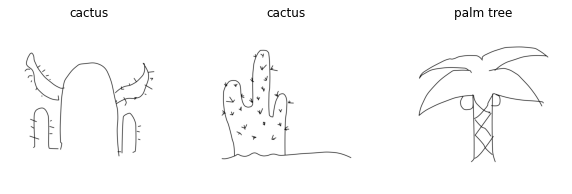

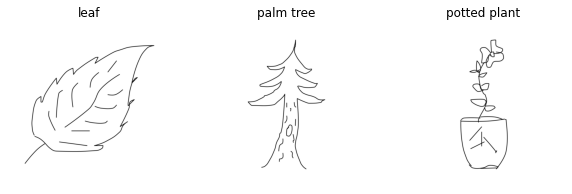

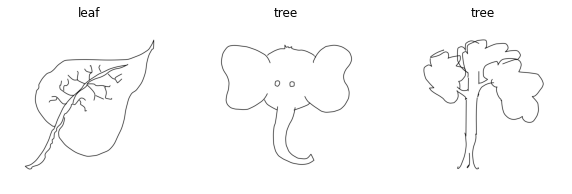

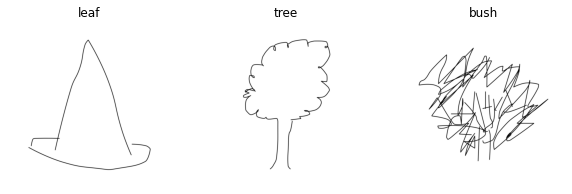

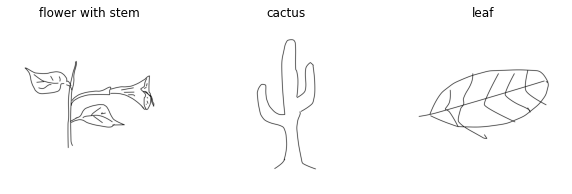

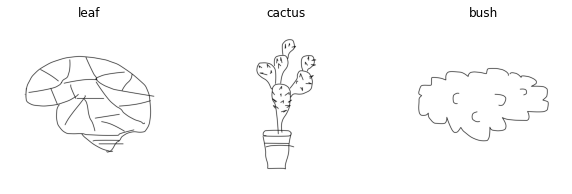

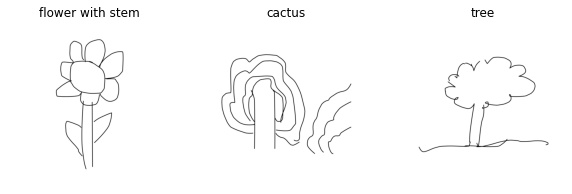

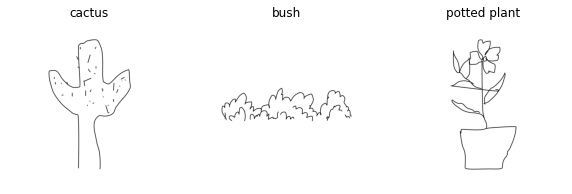

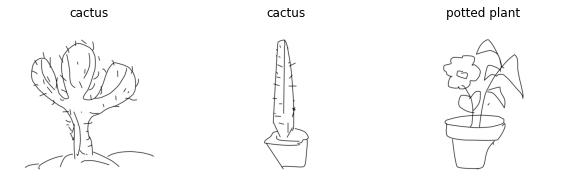

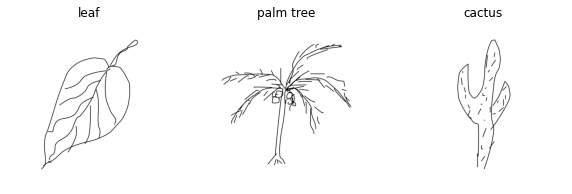

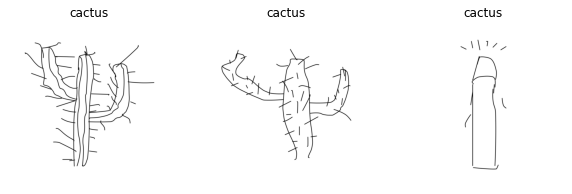

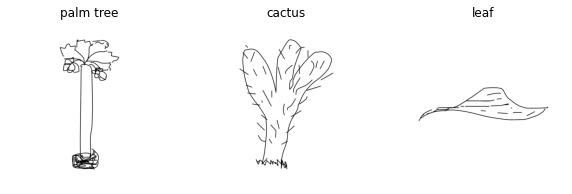

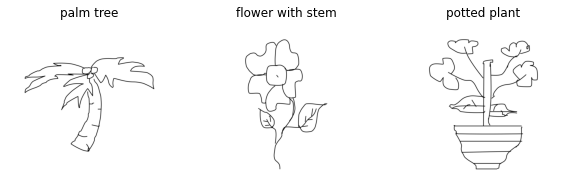

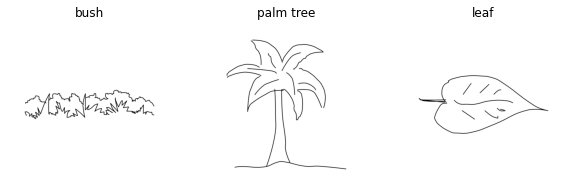

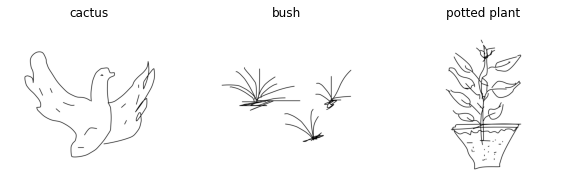

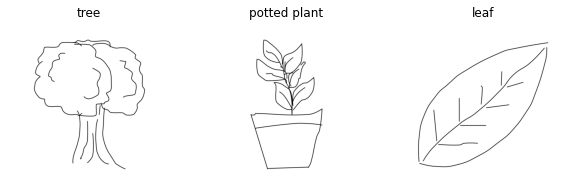

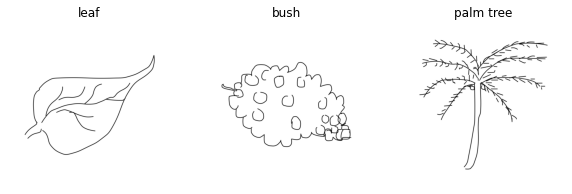

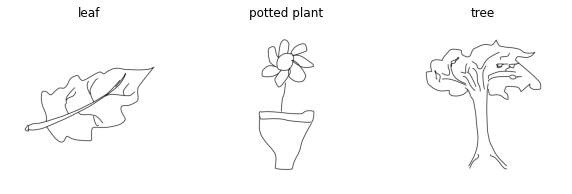

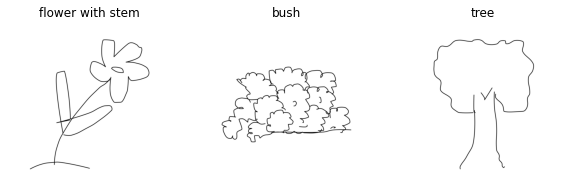

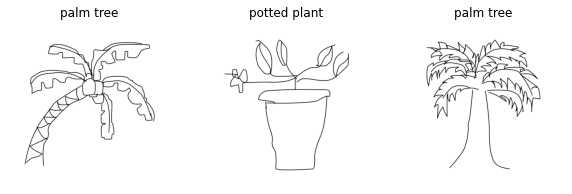

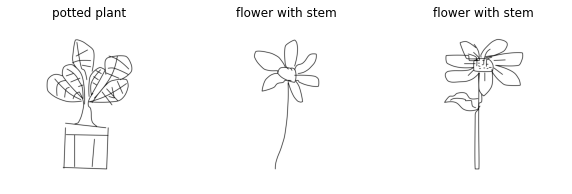

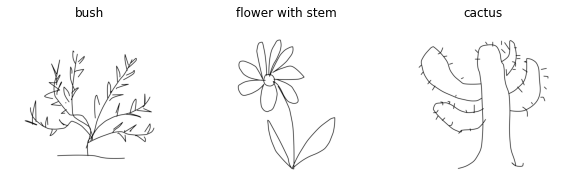

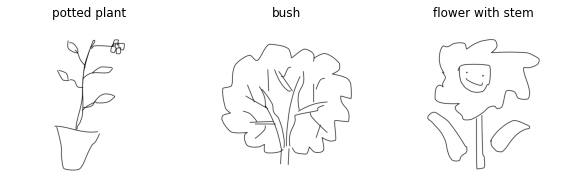

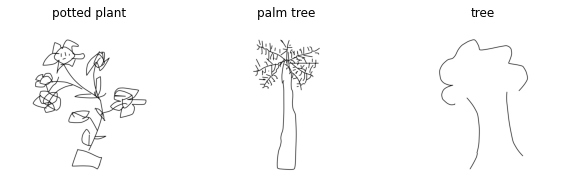

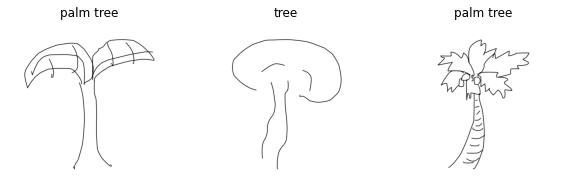

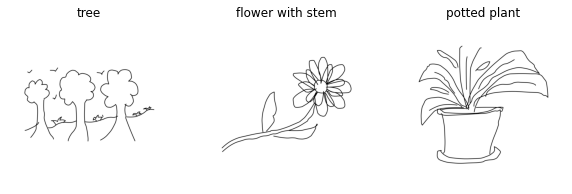

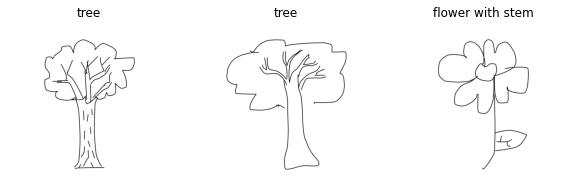

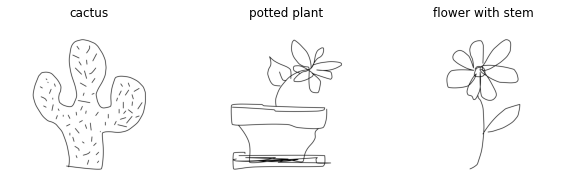

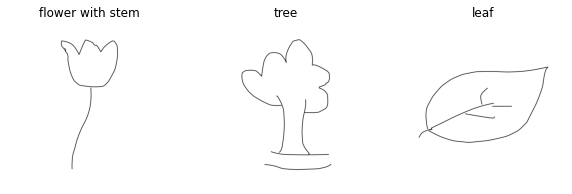

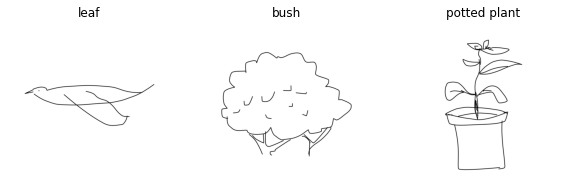

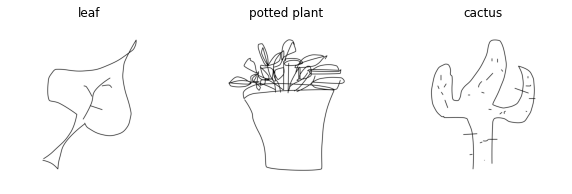

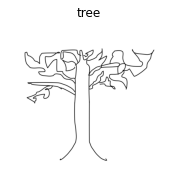

In [ ]:
display_cluster(df=updated_df, cluster_no=7, src_dir=src_dir, no_of_imgs_in_row=3)

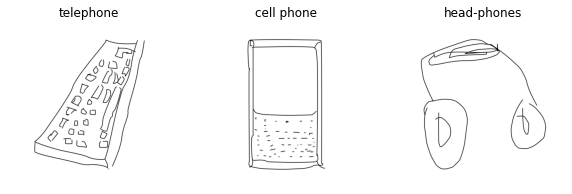

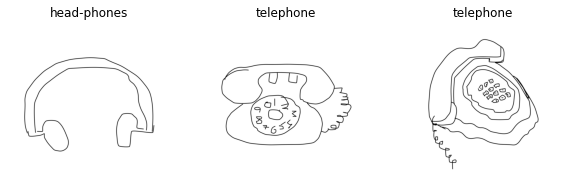

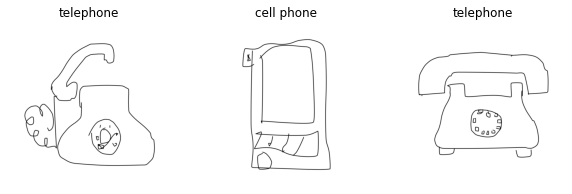

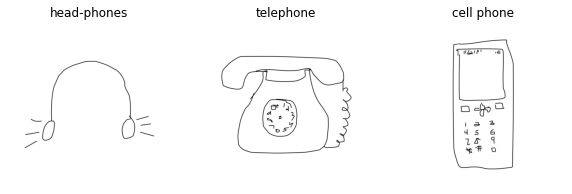

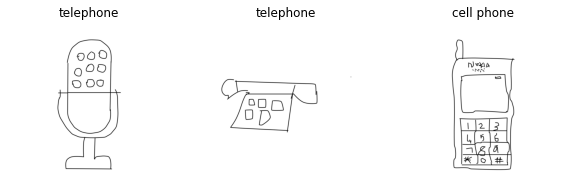

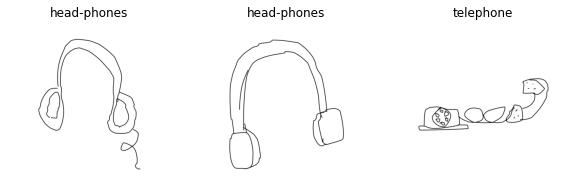

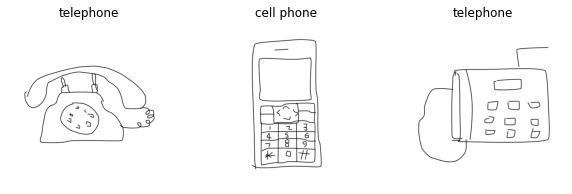

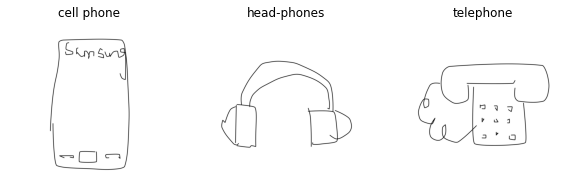

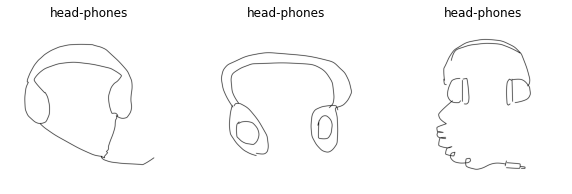

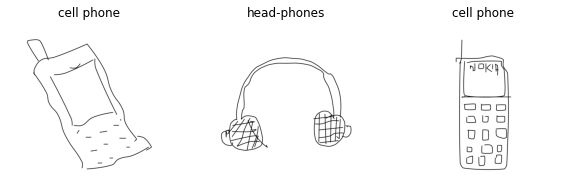

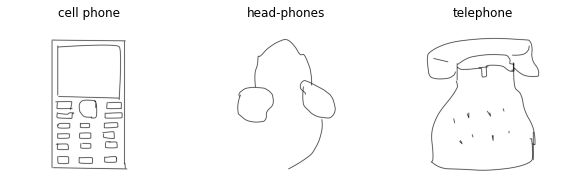

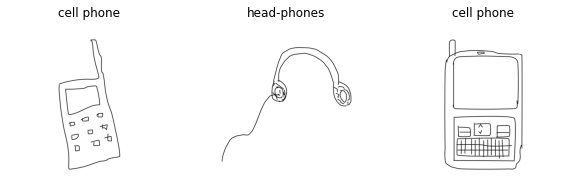

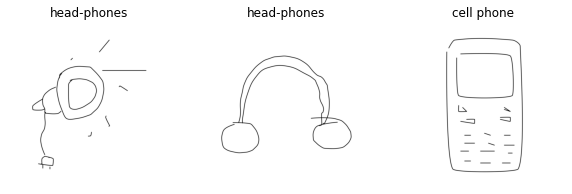

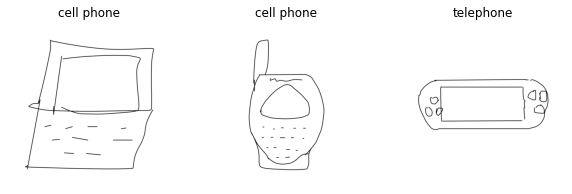

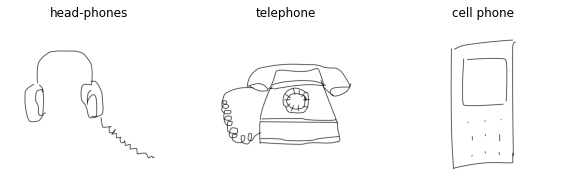

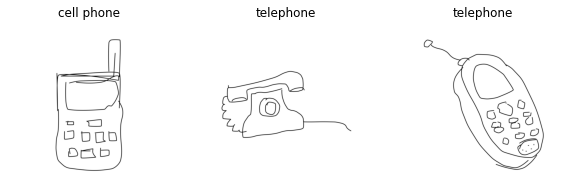

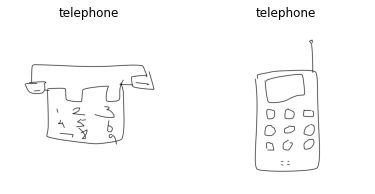

In [ ]:
display_cluster(df=updated_df, cluster_no=31, src_dir=src_dir, no_of_imgs_in_row=3)

In [ ]:
learn.export('res34-789.pkl')

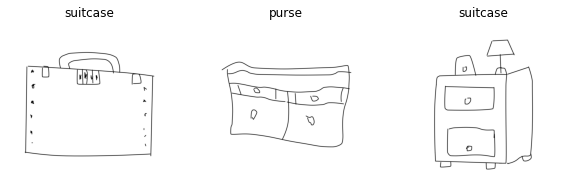

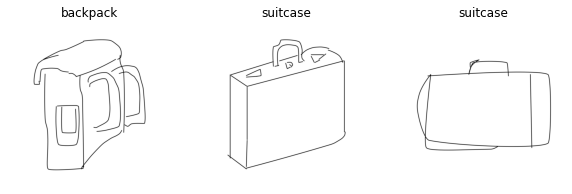

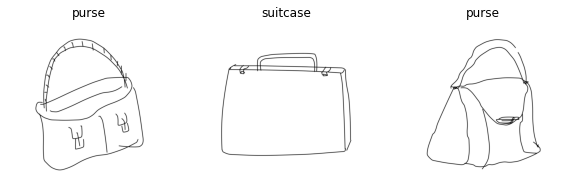

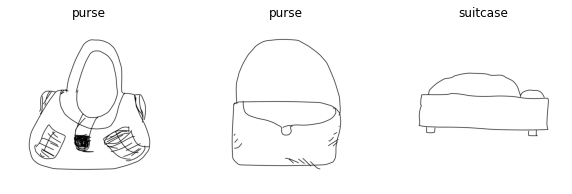

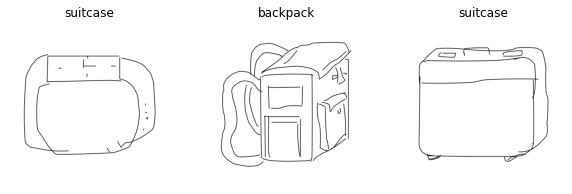

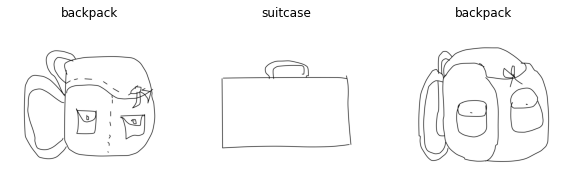

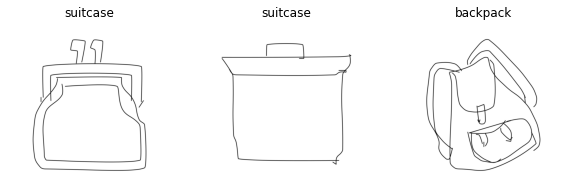

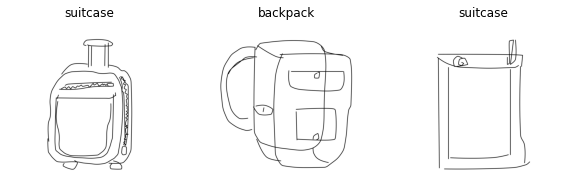

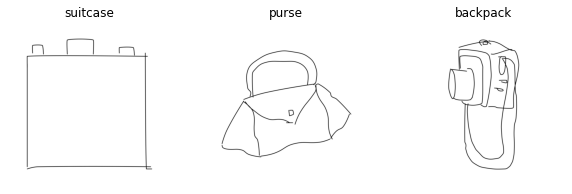

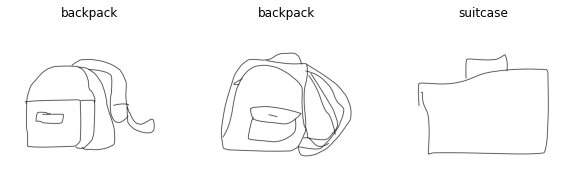

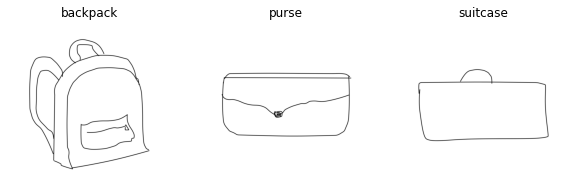

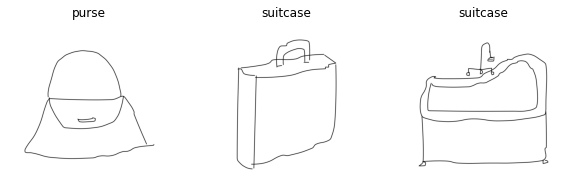

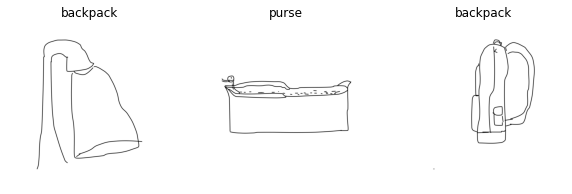

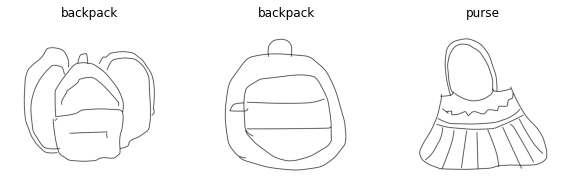

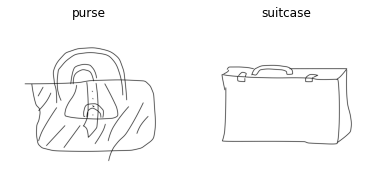

In [ ]:
display_cluster(df=updated_df, cluster_no=47, src_dir=src_dir, no_of_imgs_in_row=3)